In [1]:
%pip install ccrvam

Note: you may need to restart the kernel to use updated packages.


> Make sure to have ccrvam's latest version installed using `pip`. More information about the latest version can be found at https://pypi.org/project/ccrvam/

Run the following upgrade commands on your terminal if you are facing issues related to `pip` or `scipy`

```
# pip install --upgrade pip
# pip install --upgrade scipy
```

In [2]:
import numpy as np
from ccrvam import GenericCCRVAM, DataProcessor

# 2-Dimensional Case 

### Create Sample Contingency Table and Initialize the GenericCCRVAM

The `GenericCCRVAM` object can be initialized with a contingency table represented as a NumPy array. For a 2D contingency table:

- `axis=0`: First variable ($X_1$) with 5 categories
- `axis=1`: Second variable ($X_2$) with 3 categories

The axis indexing follows NumPy's convention, starting from the outermost dimension. The variables are ordered such that:

- $X_1$ corresponds to (rows)
- $X_2$ corresponds to (columns)

This ordering is important for calculating measures of regression association between two variables.

In [3]:
contingency_table = np.array([
    [0, 0, 20],
    [0, 10, 0],
    [20, 0, 0],
    [0, 10, 0],
    [0, 0, 20]
])

ccrvam_2d = GenericCCRVAM.from_contingency_table(contingency_table)
print(f"Dimension of the inferred joint probability matrix P: {ccrvam_2d.P.shape}")
print(f"Joint Probability matrix P:\n{ccrvam_2d.P}")

Dimension of the inferred joint probability matrix P: (5, 3)
Joint Probability matrix P:
[[0.    0.    0.25 ]
 [0.    0.125 0.   ]
 [0.25  0.    0.   ]
 [0.    0.125 0.   ]
 [0.    0.    0.25 ]]


### Calculating the Checkerboard Copula Scores (CCS) and their Variances

In [4]:
# Calculate and display scores for both variables
scores_X1 = ccrvam_2d.calculate_ccs(1)
scores_X2 = ccrvam_2d.calculate_ccs(2)

print("Checkerboard Copula Scores (CCS) for X1:")
print(scores_X1)
# Expected: [0.125, 0.3125, 0.5, 0.6875, 0.875]

print("\nCheckerboard Copula Scores (CCS) for X2:")
print(scores_X2)
# Expected: [0.125, 0.375, 0.75]

# Calculate and display variance of scores
variance_ccs_X1 = ccrvam_2d.calculate_variance_ccs(1)
variance_ccs_X2 = ccrvam_2d.calculate_variance_ccs(2)

print("\nVariance of Checkerboard Copula Scores (CCS) for X1:", variance_ccs_X1)
# Expected: 81/1024 = 0.0791015625
print("Variance of Checkerboard Copula Scores (CCS) for X2:", variance_ccs_X2)
# Expected: 9/128 = 0.0703125 

Checkerboard Copula Scores (CCS) for X1:
[np.float64(0.125), np.float64(0.3125), np.float64(0.5), np.float64(0.6875), np.float64(0.875)]

Checkerboard Copula Scores (CCS) for X2:
[np.float64(0.125), np.float64(0.375), np.float64(0.75)]

Variance of Checkerboard Copula Scores (CCS) for X1: 0.0791015625
Variance of Checkerboard Copula Scores (CCS) for X2: 0.0703125


### Category Prediction Using Checkerboard Copula Regression (CCR)

We can use the Checkerboard Copula Regression (CCR) for predicting the category of the ordinal response variable for each combination of categories of predictors. The `get_category_predictions_ccr()` method:

- Predicts the categories of response variable (to be passed in as `response` input argument) given predictor values (to be listed in `predictors` input argument)
- Returns predictions in an easy-to-read DataFrame format
- Supports custom variable names for better interpretation (Optional)

In [5]:
predictions_X1_to_X2 = ccrvam_2d.get_predictions_ccr(predictors=[1], response=2)
print("\nPredictions from X1 to X2:")
print(predictions_X1_to_X2)

# Example: Showcasing the use of custom variable names for the output
variable_to_name_dict = {1: "Income Bracket", 2: "Education Level"}
predictions_Education_to_Income = ccrvam_2d.get_predictions_ccr(predictors=[2], response=1, variable_names=variable_to_name_dict)
print("\nPredictions from Education Level to Income Bracket:")
print(predictions_Education_to_Income)


Predictions from X1 to X2:
   X1 Category  Predicted Response Category
0            1                            3
1            2                            2
2            3                            1
3            4                            2
4            5                            3

Predictions from Education Level to Income Bracket:
   Education Level Category  Predicted Income Bracket Category
0                         1                                  3
1                         2                                  3
2                         3                                  3


### Calculating CCRAM & SCCRAM

The CCRAM (Checkerboard Copula Regression Association Measure) allows us to quantify the regression relationship between an ordinal response variable and a set of categorical predictors. In our example:

- (Default) Variables: $X_1$ (rows) and $X_2$ (columns)
- X1 to X2 ($X_1 \rightarrow X_2$) measures how much X1 (to be listed in `predictors` input argument) explains the variation in X2 (to be passed in as `response` input argument) 
- Scaled version (SCCRAM) normalizes the CCRAM for properly assessing the magnitude of regression association  by taking into account the upperbound of the CCRAM. 

In [6]:
ccram_X1_to_X2 = ccrvam_2d.calculate_CCRAM(predictors=[1], response=2)
ccram_X2_to_X1 = ccrvam_2d.calculate_CCRAM(predictors=[2], response=1)
print(f"CCRAM X1 to X2: {ccram_X1_to_X2:.4f}")
print(f"CCRAM X2 to X1: {ccram_X2_to_X1:.4f}")

sccram_X1_to_X2 = ccrvam_2d.calculate_CCRAM(predictors=[1], response=2, scaled=True)
sccram_X2_to_X1 = ccrvam_2d.calculate_CCRAM(predictors=[2], response=1, scaled=True)
print(f"SCCRAM X1 to X2: {sccram_X1_to_X2:.4f}")
print(f"SCCRAM X2 to X1: {sccram_X2_to_X1:.4f}")

CCRAM X1 to X2: 0.8438
CCRAM X2 to X1: 0.0000
SCCRAM X1 to X2: 1.0000
SCCRAM X2 to X1: 0.0000


# 4-Dimensional Case (Real Data Analysis)

### Load the data in three types of form (case form, frequency form and table form) and Initialize the GenericCCRVAM

This example demonstrates how one can analyze relationships between multiple categorical variables in a clinical dataset of back pain treatments using the GenericCCRVAM object.

The dataset contains 4 categorical variables from a medical study:

| Variable | Description | Categories |
|----------|-------------|------------|
| X₁ | Length of Previous Attack | 1=Short, 2=Long |
| X₂ | Pain Change | 1=Better, 2=Same, 3=Worse |
| X₃ | Lordosis | 1=Absent/Decreasing, 2=Present/Increasing |
| Pain | Back Pain Outcome | worse (W)=1, same (S)=2, slight.improvement (SI)=3, moderate.improvement (MODI)=4, marked.improvement (MARI)=5, complete.relief (CR)=6 |

1. Define variable names, and dimension tuple (the number of categores of each variable according to the order of the variables defined) 
2. (Optional) If your data has any variables with category names that are not integers, then create a category mapping for non-integer categories (for instance, required for 'pain' variable in the above dataset)
3. Load case-form/freq-form data from file (from path provided as an argument) or type table-form with proper mappings into a contingency table
4. Initialize GenericCCRVAM object from contingency table
5. Extract and print:
   - Joint probability matrix P
   - Marginal probability distributions
   - Marginal cumulative distributions  
   - Conditional probability distributions

Citation for the above dataset:
- J. A. Anderson, Regression and ordered categorical variables, Journal of the Royal Statistical Society: Series B (Methodological) 46 (1984)
1–22.

In [7]:
var_list_4d = ["x1", "x2", "x3", "pain"]
category_map_4d = {
    "pain": {
        "worse": 1,
        "same": 2,
        "slight.improvement": 3,
        "moderate.improvement": 4,
        "marked.improvement": 5,
        "complete.relief": 6
    },
}
data_dimension = (2, 3, 2, 6)
contingency_table_4d = DataProcessor.load_data(
                        "./data/caseform.pain.txt",
                        data_form="case_form",
                        dimension=data_dimension,
                        var_list=var_list_4d,
                        category_map=category_map_4d,
                        named=True,
                        delimiter="\t"
                    )
print("Read contingency table from case form data:")
rda_ccrvam = GenericCCRVAM.from_contingency_table(contingency_table_4d)
print(f"Dimension of the inferred joint probability matrix P: {rda_ccrvam.P.shape}")
print(f"Joint Probability matrix P:\n{rda_ccrvam.P}\n")

Read contingency table from case form data:
Dimension of the inferred joint probability matrix P: (2, 3, 2, 6)
Joint Probability matrix P:
[[[[0.         0.00990099 0.         0.         0.01980198 0.03960396]
   [0.         0.         0.         0.00990099 0.02970297 0.        ]]

  [[0.         0.01980198 0.02970297 0.         0.05940594 0.03960396]
   [0.         0.00990099 0.         0.01980198 0.         0.00990099]]

  [[0.         0.         0.         0.         0.01980198 0.01980198]
   [0.         0.         0.00990099 0.00990099 0.02970297 0.        ]]]


 [[[0.         0.         0.02970297 0.         0.00990099 0.01980198]
   [0.         0.00990099 0.         0.         0.02970297 0.        ]]

  [[0.         0.02970297 0.03960396 0.04950495 0.05940594 0.01980198]
   [0.00990099 0.03960396 0.03960396 0.02970297 0.         0.00990099]]

  [[0.01980198 0.01980198 0.00990099 0.04950495 0.01980198 0.        ]
   [0.01980198 0.         0.01980198 0.02970297 0.         0.       

In [8]:
contingency_table_4d_from_freq = DataProcessor.load_data(
                        "./data/freqform.pain.txt",
                        data_form="frequency_form",
                        dimension=data_dimension,
                        var_list=var_list_4d,
                        category_map=category_map_4d,
                        named=True,
                        delimiter="\t"
                    )
print("Read contingency table from freq form data:")
rda_ccrvam_from_freq = GenericCCRVAM.from_contingency_table(contingency_table_4d_from_freq)
print(f"Dimension of the inferred joint probability matrix P: {rda_ccrvam_from_freq.P.shape}")
print(f"Joint Probability matrix P:\n{rda_ccrvam_from_freq.P}\n")

Read contingency table from freq form data:
Dimension of the inferred joint probability matrix P: (2, 3, 2, 6)
Joint Probability matrix P:
[[[[0.         0.00990099 0.         0.         0.01980198 0.03960396]
   [0.         0.         0.         0.00990099 0.02970297 0.        ]]

  [[0.         0.01980198 0.02970297 0.         0.05940594 0.03960396]
   [0.         0.00990099 0.         0.01980198 0.         0.00990099]]

  [[0.         0.         0.         0.         0.01980198 0.01980198]
   [0.         0.         0.00990099 0.00990099 0.02970297 0.        ]]]


 [[[0.         0.         0.02970297 0.         0.00990099 0.01980198]
   [0.         0.00990099 0.         0.         0.02970297 0.        ]]

  [[0.         0.02970297 0.03960396 0.04950495 0.05940594 0.01980198]
   [0.00990099 0.03960396 0.03960396 0.02970297 0.         0.00990099]]

  [[0.01980198 0.01980198 0.00990099 0.04950495 0.01980198 0.        ]
   [0.01980198 0.         0.01980198 0.02970297 0.         0.       

If you are interested in logging in the data in contingency table format, then that can be done as follows. The 4-dimensional contingency table represents counts for combinations of categories of each of 4 variables:

The dimension of the table is (2,3,2,6) corresponding to the number of categories for each variable according to the order of the variables defined in `var_list_4d`. The innermost arrays contain counts for the 6 possible back pain outcomes, and are nested within the structure for the other variables.

Here's how to understand the array structure:

```python
# The table is structured as a 4D numpy array with table dimension (2,3,2,6)
table = np.array([
    # First level: X₁=1 (Short)
    [
        # Second level: X₂=1 (Better)
        [
            # Third level: X₃=1 (Absent)
            [0,1,0,0,2,4],  # Fourth level: Counts for each X₄ outcome
            # Third level: X₃=2 (Present) 
            [0,0,0,1,3,0]
        ],
        # Second level: X₂=2 (Same)
        [...],
        # Second level: X₂=3 (Worse) 
        [...]
    ],
    # First level: X₁=2 (Long)
    [...]
])
```

We demonstrate how to load the data using contingency table as input below:

In [9]:
table = np.array([[[[0, 1, 0, 0, 2, 4],
                    [0, 0, 0, 1, 3, 0]],
                    [[0, 2, 3, 0, 6, 4],
                    [0, 1, 0, 2, 0, 1]],
                    [[0, 0, 0, 0, 2, 2],
                    [0, 0, 1, 1, 3, 0]]],
                    [[[0, 0, 3, 0, 1, 2],
                    [0, 1, 0, 0, 3, 0]],
                    [[0, 3, 4, 5, 6, 2],
                    [1, 4, 4, 3, 0, 1]],
                    [[2, 2, 1, 5, 2, 0],
                    [2, 0, 2, 3, 0, 0]]]])
contingency_table_4d_from_array = DataProcessor.load_data(
                        table,
                        data_form="table_form",
                        dimension=data_dimension,
                        var_list=var_list_4d,
                        category_map=category_map_4d,
                    )
print("Read contingency table from table form data:")
rda_ccrvam_from_array = GenericCCRVAM.from_contingency_table(contingency_table_4d_from_array)
print(f"Dimension of the inferred joint probability matrix P: {rda_ccrvam_from_array.P.shape}")
print(f"Joint Probability matrix P:\n{rda_ccrvam_from_array.P}\n")

Read contingency table from table form data:
Dimension of the inferred joint probability matrix P: (2, 3, 2, 6)
Joint Probability matrix P:
[[[[0.         0.00990099 0.         0.         0.01980198 0.03960396]
   [0.         0.         0.         0.00990099 0.02970297 0.        ]]

  [[0.         0.01980198 0.02970297 0.         0.05940594 0.03960396]
   [0.         0.00990099 0.         0.01980198 0.         0.00990099]]

  [[0.         0.         0.         0.         0.01980198 0.01980198]
   [0.         0.         0.00990099 0.00990099 0.02970297 0.        ]]]


 [[[0.         0.         0.02970297 0.         0.00990099 0.01980198]
   [0.         0.00990099 0.         0.         0.02970297 0.        ]]

  [[0.         0.02970297 0.03960396 0.04950495 0.05940594 0.01980198]
   [0.00990099 0.03960396 0.03960396 0.02970297 0.         0.00990099]]

  [[0.01980198 0.01980198 0.00990099 0.04950495 0.01980198 0.        ]
   [0.01980198 0.         0.01980198 0.02970297 0.         0.      

In [10]:
print("Marginal pdfs:")
for idx, marginal_pdf in rda_ccrvam.marginal_pdfs.items():
    print(f"Case-form Marginal pdf for {var_list_4d[idx]}: {marginal_pdf}")

print("\nMarginal cdfs:")
for idx, marginal_cdf in rda_ccrvam.marginal_cdfs.items():
    print(f"Case-form Marginal cdf for {var_list_4d[idx]}: {marginal_cdf}")

Marginal pdfs:
Case-form Marginal pdf for x1: [0.38613861 0.61386139]
Case-form Marginal pdf for x2: [0.20792079 0.51485149 0.27722772]
Case-form Marginal pdf for x3: [0.63366337 0.36633663]
Case-form Marginal pdf for pain: [0.04950495 0.13861386 0.17821782 0.1980198  0.27722772 0.15841584]

Marginal cdfs:
Case-form Marginal cdf for x1: [0.         0.38613861 1.        ]
Case-form Marginal cdf for x2: [0.         0.20792079 0.72277228 1.        ]
Case-form Marginal cdf for x3: [0.         0.63366337 1.        ]
Case-form Marginal cdf for pain: [0.         0.04950495 0.18811881 0.36633663 0.56435644 0.84158416
 1.        ]


### Calculating Checkerboard Copula Scores (CCS) and their Variances

In [11]:
rda_scores_X1 = rda_ccrvam.calculate_ccs(1)
rda_scores_X2 = rda_ccrvam.calculate_ccs(2)
rda_scores_X3 = rda_ccrvam.calculate_ccs(3)
rda_scores_pain = rda_ccrvam.calculate_ccs(4)

print("Checkerboard Copula Scores (CCS) for X1:")
print(rda_scores_X1)
print("\nCheckerboard Copula Scores (CCS) for X2:")
print(rda_scores_X2)
print("\nCheckerboard Copula Scores (CCS) for X3:")
print(rda_scores_X3)
print("\nCheckerboard Copula Scores (CCS) for Pain:")
print(rda_scores_pain)

# Calculate and display variance of scores
rda_variance_ccs_X1 = rda_ccrvam.calculate_variance_ccs(1)
rda_variance_ccs_X2 = rda_ccrvam.calculate_variance_ccs(2)
rda_variance_ccs_X3 = rda_ccrvam.calculate_variance_ccs(3)
rda_variance_ccs_pain = rda_ccrvam.calculate_variance_ccs(4)

print("\nVariance of Checkerboard Copula scores (CCS) for X1:", rda_variance_ccs_X1)
print("\nVariance of Checkerboard Copula scores (CCS) for X2:", rda_variance_ccs_X2)
print("\nVariance of Checkerboard Copula scores (CCS) for X3:", rda_variance_ccs_X3)
print("\nVariance of Checkerboard Copula scores (CCS) for Pain:", rda_variance_ccs_pain)
# Expected 12 * (variance of Checkerboard Copula scores for Pain): 0.07987568681385342*12 = 0.95850824176

Checkerboard Copula Scores (CCS) for X1:
[np.float64(0.19306930693069307), np.float64(0.693069306930693)]

Checkerboard Copula Scores (CCS) for X2:
[np.float64(0.10396039603960396), np.float64(0.4653465346534653), np.float64(0.8613861386138614)]

Checkerboard Copula Scores (CCS) for X3:
[np.float64(0.31683168316831684), np.float64(0.8168316831683169)]

Checkerboard Copula Scores (CCS) for Pain:
[np.float64(0.024752475247524754), np.float64(0.1188118811881188), np.float64(0.27722772277227725), np.float64(0.4653465346534653), np.float64(0.7029702970297029), np.float64(0.9207920792079207)]

Variance of Checkerboard Copula scores (CCS) for X1: 0.059258896186648376

Variance of Checkerboard Copula scores (CCS) for X2: 0.06943601918274368

Variance of Checkerboard Copula scores (CCS) for X3: 0.058033526124889726

Variance of Checkerboard Copula scores (CCS) for Pain: 0.07987568681385343


### Category Prediction Using Checkerboard Copula Regression (CCR)

We can use the Checkerboard Copula Regression (CCR) for predicting the category of the ordinal response variable for each combination of categories of predictors. The `get_category_predictions_ccr()` method:

- Predicts the categories of response variable (to be passed in as `response` input argument) given predictor values (to be listed in `predictors` input argument)
- Returns predictions in an easy-to-read DataFrame format
- Supports custom variable names for better interpretation (Optional)

In [12]:
rda_predictions_with_default_naming = rda_ccrvam.get_predictions_ccr(predictors=[1, 2, 3], response=4)
print("\nPredictions from X1, X2, X3 to Pain:")
print(rda_predictions_with_default_naming)

rda_variable_to_name_dict = {1: "Length of Previous Attack", 2: "Pain Change", 3: "Lordosis", 4: "Back Pain"}
rda_predictions_X1_X2_X3_to_Pain_named = rda_ccrvam.get_predictions_ccr(predictors=[1, 2, 3], response=4, variable_names=rda_variable_to_name_dict)
print("\nPredictions from Length of Previous Attack, Pain Change, Lordosis to Back Pain:")
rda_predictions_X1_X2_X3_to_Pain_named


Predictions from X1, X2, X3 to Pain:
    X1 Category  X2 Category  X3 Category  Predicted Response Category
0             1            1            1                            5
1             1            1            2                            5
2             1            2            1                            5
3             1            2            2                            4
4             1            3            1                            5
5             1            3            2                            5
6             2            1            1                            4
7             2            1            2                            4
8             2            2            1                            4
9             2            2            2                            3
10            2            3            1                            3
11            2            3            2                            3

Predictions from Length of Previous At

,Length of Previous Attack Category,Pain Change Category,Lordosis Category,Predicted Back Pain Category
0,1,1,1,5
1,1,1,2,5
2,1,2,1,5
3,1,2,2,4
4,1,3,1,5
5,1,3,2,5
6,2,1,1,4
7,2,1,2,4
8,2,2,1,4
9,2,2,2,3


### Heatmap Representations of the Category Prediction

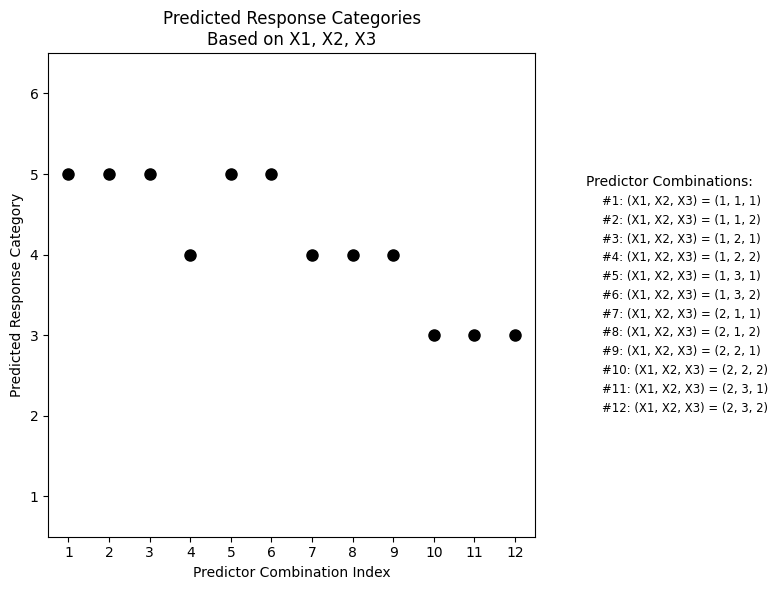

In [ ]:
# Plotting with default naming scheme and legend
rda_ccrvam.plot_ccr_predictions(predictors=[1,2,3], response=4)

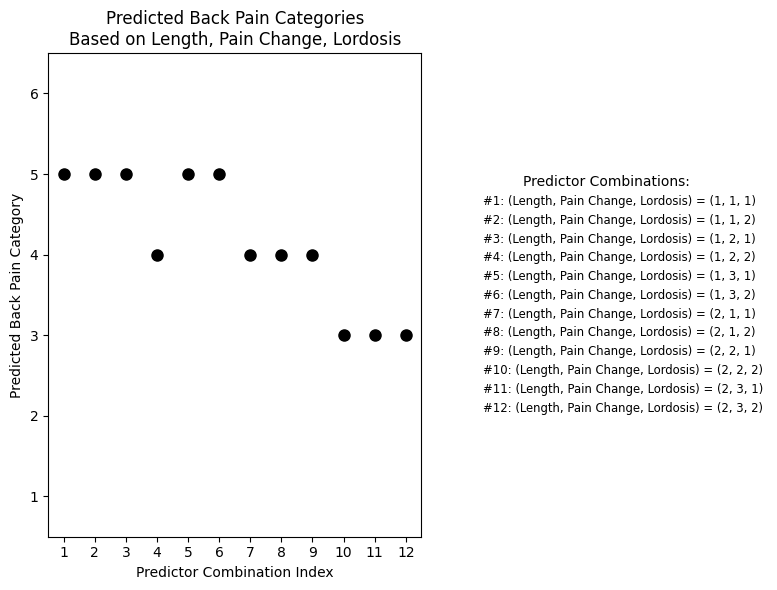

In [ ]:
# Plotting with legend and custom naming scheme inputted by user
var_names={1:"Length", 2:"Pain Change", 3:"Lordosis", 4:"Back Pain"}
rda_ccrvam.plot_ccr_predictions(predictors=[1,2,3], response=4, variable_names=var_names)

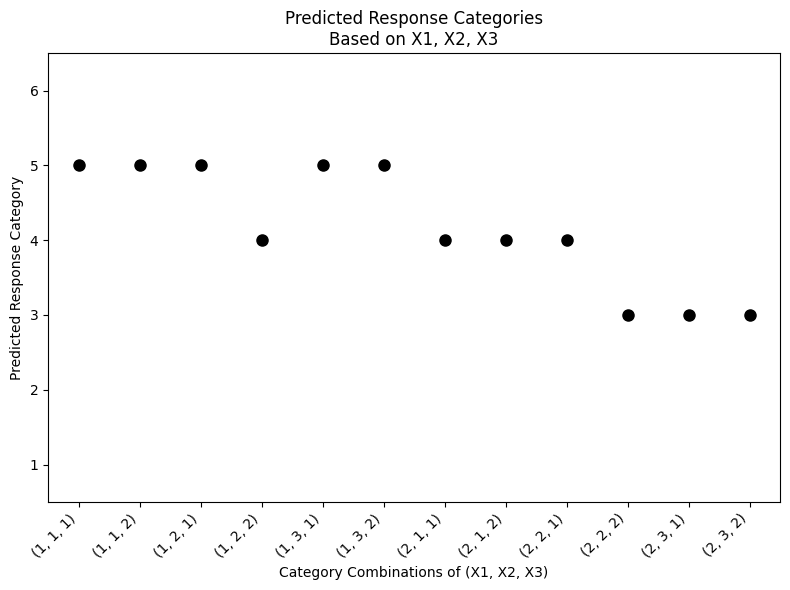

In [16]:
# Plotting with default naming scheme, but without legend (tuple labels instead on x-axis)
rda_ccrvam.plot_ccr_predictions(predictors=[1,2,3], response=4, legend_style="xaxis")

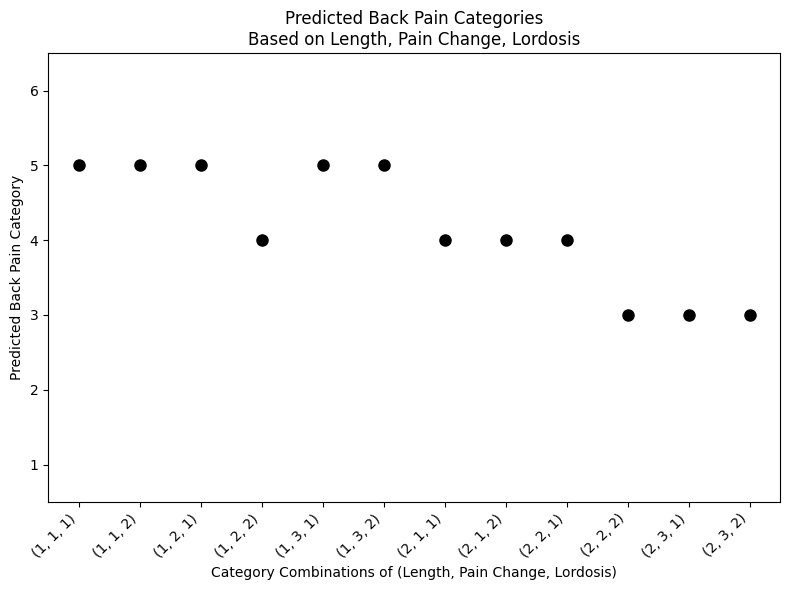

In [17]:
# Plotting with custom naming scheme inputted by user, but without legend (tuple labels instead on x-axis)
var_names={1:"Length", 2:"Pain Change", 3:"Lordosis", 4:"Back Pain"}
rda_ccrvam.plot_ccr_predictions(predictors=[1,2,3], response=4, legend_style="xaxis", variable_names=var_names)

### Calculating CCRAM & SCCRAM

The CCRAM (Checkerboard Copula Regression Association Measure) allows us to quantify the regression relationship between an ordinal response variable and a set of categorical predictors. In our example:

- Variables: $X_1$, $X_2$, $X_3$, Pain.
- (X1, X2, X3) to Pain ($(X_1, X_2, X_3) \rightarrow Pain$) measures how much (X1, X2, X3) (to be listed in `predictors` input argument) explain the variation in Pain (to be passed in as `response` input argument) 
- Scaled version (SCCRAM) normalizes the CCRAM for properly assessing the magnitude of regression association  by taking into account the upperbound of the CCRAM. 

In [18]:
rda_ccram_X1_X2_X3_to_Pain = rda_ccrvam.calculate_CCRAM(predictors=[1, 2, 3], response=4)
print(f"CCRAM from (X1, X2, X3) to Pain: {rda_ccram_X1_X2_X3_to_Pain:.4f}")

rda_sccram_X1_X2_X3_to_X4 = rda_ccrvam.calculate_CCRAM(predictors=[1, 2, 3], response=4, scaled=True)
print(f"SCCRAM from (X1, X2, X3) to Pain: {rda_sccram_X1_X2_X3_to_X4:.4f}")

CCRAM from (X1, X2, X3) to Pain: 0.2576
SCCRAM from (X1, X2, X3) to Pain: 0.2687
